## Imports

In [ ]:
import numpy as np
import pandas as pd
import os
import random as rd
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

#from analysis_utils.ClassifierPlots import create_reliability_diagram, create_roc_curve, create_feature_importance_plot
#from analysis_utils.Analysis import print_accuracy_and_classification_report, predict_classes, get_somatic_error_type

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from scipy.stats import pearsonr
import matplotlib.ticker as ticker
from itertools import cycle

sns.set_style('white')


def _calculate_hist(probabilities,
                    bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]):
    '''Calculates the counts and mean of each bin for a histogram using \
    defined bin intervals.

    Parameters:
        probabilities (numpy.array): Array of probabilites
        bins (list): Defined bins to calculate. Default [0,.1,.2,.3,.4,
                     .5,.6,.7,.8,.9,1]
    Returns:
        (counts, means): Lists of the counts and means of each bin
    '''
    counts = list()
    means = list()
    for i in range(0, len(bins) - 1):
        count = len(probabilities[(probabilities > bins[i])
                                  & (probabilities <= bins[i + 1])])
        if count == 0:
            counts.append(0)
            bin_mean = np.mean([bins[i], bins[i+1]])
            means.append(bin_mean)
        else:
            counts.append(count)
            means.append(np.mean(probabilities[(probabilities > bins[i]) &
                                               (probabilities <= bins[i + 1])])
                         )
    return np.array(counts), np.array(means)

def create_roc_curve(Y, probabilities, class_lookup, title, ax):
    '''Create ROC curve to compare multiclass model performance.

    Parameters:
        Y (numpy.array): Truth labels
        probabilities (numpy.array): Output of model for each class
        class_lookup (dict): lookup hash of truth labels
        title (str): Plot title
    '''
    n_classes = Y.shape[1]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    ax.set_title(title)
    if n_classes == 3:
        colors = cycle(['orange', 'red', 'black'])
    else:
        colors = cycle(['orange', 'red', 'aqua', 'black'])
    for i, color in zip(range(n_classes), colors):
        fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], probabilities[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        ax.plot(fpr[i], tpr[i], color=color,
                label='ROC curve of class {0} (area = {1:0.2f})'.format(
                    class_lookup[i], roc_auc[i]))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    # plt.show()


def create_feature_importance_plot(feature_importance_metrics, title):
    '''Create bar plot illustrating importance of each feature.

    Parameters:
        feature_importance_metrics (pandas.DataFrame): DataFrame with features
                                                       on index and a column
                                                       named delta_auc
                                                       containing the change
                                                       in roc auc values
        title (str): Title of plot
    '''
    feature_importance_metrics.replace(
        {'feature': {'var': 'variant', 'ref': 'reference',
                     'avg': 'average',
                     '_se_': '_single_end_',
                     '3p': '3_prime', '_': ' '}},
        regex=True, inplace=True)
    sns.barplot(y='feature', x='delta_auc',
                data=feature_importance_metrics.head(30),
                color='cornflowerblue')
    plt.xlabel('Delta average AUC')
    plt.ylabel('Feature')
    plt.title(title)


def make_model_output_plot(probabilities, title):
    """Make plot that show the distribution of model output

        Parameters:
            probabilities (numpy.array): array of model output with samples
                                         on row and classes in columns
            title (str): Plot title
    """
    ax = sns.distplot(probabilities[:, 0:1])
    sns.distplot(probabilities[:, 1:2], ax=ax)
    sns.distplot(probabilities[:, 2:3], ax=ax)
    ax.legend(['Ambiguous', 'Fail', 'Somatic'])
    ax.set_xlabel('Model output')
    ax.set_ylabel('Density')
    ax.set_title(title)


In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import preprocessing

def get_roc_auc(probabilities, Y):
    # for binary classifier add labels for fail category
    if len(Y.shape) == 1:
        Y = np.array([np.logical_not(Y), Y]).T
    n_classes = Y.shape[1]
    fpr = [0] * n_classes
    tpr = [0] * n_classes
    roc_auc = [0] * n_classes
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], probabilities[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    return np.mean(roc_auc)


def print_accuracy_and_classification_report(labels, prediction):
    """Print model accuracy and classification report.

    Args:
        labels (numpy.array): Truth lables
        prediction (numpy.array): Model predictions
    """
    print('Cross validation accuracy:')
    print('\t', metrics.accuracy_score(labels, prediction))
    print('\nCross validation classification report\n')
    print(metrics.classification_report(labels, prediction))


def predict_classes(probabilities):
    """Predict class labels from probabilities

    Args:
        probabilities (numpy.array): model output for each class
    Returns:
        (numpy.array): Model predicted class labels
    """
    predicted = np.array(
        [list(a).index(max(list(a))) for a in list(probabilities)])
    label_binarizer = preprocessing.LabelBinarizer()

    label_binarizer.fit(range(max(predicted) + 1))
    return label_binarizer.transform(predicted)


## Read the data

In [ ]:
df=pd.read_excel('Data.xlsx')

In [ ]:
df.head()

,Column1,3-Breast-Her2-ampl,8-Breast-WT,10-Breast-Her2-ampl,Breast-100,15-Breast-Her2-ampl,16-Breast-WT,21-Breast-WT,33-Breast-Her2-ampl,42-Breast-Her2-ampl,Breast-454,48-Breast-WT,50-Breast-WT,55-Breast-WT,Type-Unknown-6,Breast-564,59-Breast-WT,Breast-590,Breast-60,Breast-603,ALK61-Breast-Her2-unknown,Breast-85,Breast-86,97-Breast-Her2-ampl,Breast-ALK-82,292-Liver-KRAS,316-Liver-KRAS,341-Liver-WT,376-Liver-WT,379-Liver-WT,Chol-410,Chol-442,Chol-460,Chol-611,Chol-ALK-28,VU256-CRC,VU258-CRC,VU272-CRC,VU276-CRC,Type-Unknown-1,...,MGH-BrCa-H-11,MGH-BrCa-H-59,MGH-BrCa-H-66,MGH-BrCa-H-68,MGH-BrCa-H-74,MGH-BrCa-H-75,MGH-CRC-368,Vumc-NSCLC-49,Vumc-NSCLC-57,Vumc-NSCLC-59,MGH-BrCa-H31-TR-489,MGH-BrCa-H38-TR467,MGH-BrCa-H63-TR-491,MGH-BrCa-H76-TR469,MGH-BrCa-H81-TR492,MGH-BrCa-H83-TR550,MGH-BrCa-H84-TR551,MGH-BrCa-H89-TR471,MGH-BrCa-H92-TR472,MGH-CRC-412-TR466,MGH-CRC-BRAF4-TR547,MGH-CRC-BRAF5-TR548,MGH-CRC-BRAF6-TR465,MGH-NSCLC-L01-TR458,MGH-NSCLC-L03-TR488,MGH-NSCLC-L07-TR459,MGH-NSCLC-L11-TR477,MGH-NSCLC-L12-TR478,MGH-NSCLC-L18-TR479,MGH-NSCLC-L19-TR461,MGH-NSCLC-L20-TR500,MGH-NSCLC-L22-TR462,MGH-NSCLC-L23-TR524,MGH-NSCLC-L25-TR480,MGH-NSCLC-L39-TR519,MGH-NSCLC-L40-TR520,MGH-NSCLC-L51-TR521,MGH-NSCLC-L58-TR525,MGH-NSCLC-L59-TR522,MGH-NSCLC-L65-TR523
0,ENSG00000000003,0,0,0,0,17,0,0,0,0,0,0,0,0,1,2,0,0,0,0,23,0,1,1,0,22,0,8,0,0,0,5,0,5,0,0,0,0,241,0,...,2,0,7,0,1,3,0,0,9,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,10,9,0,0,0,0,0,0
1,ENSG00000000005,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ENSG00000000419,44,14,16,8,9,0,139,108,55,7,27,0,0,24,12,102,93,1,10,41,4,16,0,9,39,13,19,61,17,18,43,5,29,30,0,1,0,180,8,...,21,0,25,11,2,30,17,14,25,40,12,2,25,18,40,6,32,12,4,0,3,24,12,0,31,27,46,42,6,30,2,41,40,15,1,0,13,0,0,10
3,ENSG00000000457,26,1,14,0,4,20,1,26,24,0,0,1,0,0,0,0,20,0,0,39,0,0,0,7,0,0,0,10,0,9,5,3,3,0,0,0,0,0,13,...,11,0,0,5,4,3,2,4,1,24,2,0,10,13,9,0,3,0,0,0,56,0,6,21,0,0,20,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ENSG00000000460,81,98,18,17,0,20,144,26,97,6,11,7,85,128,28,224,120,21,16,20,21,20,80,27,28,37,25,43,23,11,18,22,35,16,28,0,3,0,37,...,38,3,5,6,19,15,5,13,15,37,41,1,17,11,79,16,8,1,36,0,17,1,48,18,23,11,12,3,9,40,23,1,6,22,30,0,1,50,6,2


In [ ]:
df_T = df.transpose()

In [ ]:
new_header = df_T.iloc[0] #grab the first row for the header
df_T = df_T[1:] #take the data less the header row
df_T.columns = new_header #set the header row as the df header

In [ ]:
# for row_name in df.index: 
#     print(row_name)

In [ ]:
df_T.shape

(285, 57736)

In [ ]:
df_T['target']='c'

In [ ]:
x=df_T.index
print(x)
print(df_T)


Index(['3-Breast-Her2-ampl', '8-Breast-WT', '10-Breast-Her2-ampl',
       'Breast-100', '15-Breast-Her2-ampl', '16-Breast-WT', '21-Breast-WT',
       '33-Breast-Her2-ampl', '42-Breast-Her2-ampl', 'Breast-454',
       ...
       'MGH-NSCLC-L20-TR500', 'MGH-NSCLC-L22-TR462', 'MGH-NSCLC-L23-TR524',
       'MGH-NSCLC-L25-TR480', 'MGH-NSCLC-L39-TR519', 'MGH-NSCLC-L40-TR520',
       'MGH-NSCLC-L51-TR521', 'MGH-NSCLC-L58-TR525', 'MGH-NSCLC-L59-TR522',
       'MGH-NSCLC-L65-TR523'],
      dtype='object', length=285)
Column1             ENSG00000000003 ENSG00000000005  ... ENSG00000273493 target
3-Breast-Her2-ampl                0               0  ...               0      c
8-Breast-WT                       0               0  ...               0      c
10-Breast-Her2-ampl               0               0  ...               0      c
Breast-100                        0               0  ...               0      c
15-Breast-Her2-ampl              17               0  ...               0      c
...   

In [ ]:
# all 280 source titles:
source_titles = "Blood_Platelets_Breast-03	Blood_Platelets_Breast-08	Blood_Platelets_Breast-10	Blood_Platelets_Breast-100	Blood_Platelets_Breast-15	Blood_Platelets_Breast-16	Blood_Platelets_Breast-21	Blood_Platelets_Breast-33	Blood_Platelets_Breast-42	Blood_Platelets_Breast-454	Blood_Platelets_Breast-48	Blood_Platelets_Breast-50	Blood_Platelets_Breast-55	Blood_Platelets_Breast-56	Blood_Platelets_Breast-564	Blood_Platelets_Breast-59	Blood_Platelets_Breast-590	Blood_Platelets_Breast-60	Blood_Platelets_Breast-603	Blood_Platelets_Breast-61	Blood_Platelets_Breast-85	Blood_Platelets_Breast-86	Blood_Platelets_Breast-97	Blood_Platelets_Breast-ALK-82	Blood_Platelets_Chol-292	Blood_Platelets_Chol-316	Blood_Platelets_Chol-341	Blood_Platelets_Chol-376	Blood_Platelets_Chol-379	Blood_Platelets_Chol-410	Blood_Platelets_Chol-442	Blood_Platelets_Chol-460	Blood_Platelets_Chol-611	Blood_Platelets_Chol-ALK-28	Blood_Platelets_CRC-256	Blood_Platelets_CRC-258	Blood_Platelets_CRC-272	Blood_Platelets_CRC-276	Blood_Platelets_CRC-304	Blood_Platelets_CRC-329	Blood_Platelets_CRC-342	Blood_Platelets_CRC-351	Blood_Platelets_CRC-354	Blood_Platelets_CRC-356	Blood_Platelets_CRC-357	Blood_Platelets_CRC-374	Blood_Platelets_CRC-378	Blood_Platelets_CRC-420	Blood_Platelets_CRC-429	Blood_Platelets_CRC-450	Blood_Platelets_CRC-453	Blood_Platelets_CRC-459	Blood_Platelets_CRC-462	Blood_Platelets_CRC-463	Blood_Platelets_CRC-466	Blood_Platelets_CRC-474	Blood_Platelets_CRC-487	Blood_Platelets_CRC-496	Blood_Platelets_CRC-497	Blood_Platelets_CRC-504	Blood_Platelets_CRC-511	Blood_Platelets_CRC-523	Blood_Platelets_CRC-524	Blood_Platelets_CRC-527	Blood_Platelets_CRC-531	Blood_Platelets_CRC-543	Blood_Platelets_CRC-546	Blood_Platelets_CRC-548	Blood_Platelets_CRC-552	Blood_Platelets_CRC-556	Blood_Platelets_CRC-565	Blood_Platelets_CRC-576	Blood_Platelets_GBM-280	Blood_Platelets_GBM-284	Blood_Platelets_GBM-306	Blood_Platelets_GBM-360	Blood_Platelets_GBM-372	Blood_Platelets_GBM-378	Blood_Platelets_GBM-383	Blood_Platelets_GBM-393	Blood_Platelets_GBM-394	Blood_Platelets_GBM-398	Blood_Platelets_GBM-402	Blood_Platelets_GBM-406	Blood_Platelets_GBM-408	Blood_Platelets_GBM-417	Blood_Platelets_GBM-418	Blood_Platelets_GBM-419	Blood_Platelets_GBM-421	Blood_Platelets_GBM-422	Blood_Platelets_GBM-425	Blood_Platelets_GBM-429	Blood_Platelets_GBM-430	Blood_Platelets_GBM-431	Blood_Platelets_GBM-436	Blood_Platelets_GBM-438	Blood_Platelets_GBM-439	Blood_Platelets_GBM-440	Blood_Platelets_GBM-443	Blood_Platelets_GBM-445	Blood_Platelets_GBM-454	Blood_Platelets_GBM-456	Blood_Platelets_GBM-468	Blood_Platelets_GBM-471	Blood_Platelets_GBM-475	Blood_Platelets_GBM-476	Blood_Platelets_GBM-480	Blood_Platelets_GBM-484	Blood_Platelets_GBM-485	Blood_Platelets_GBM-486	Blood_Platelets_GBM-499	Blood_Platelets_GBM-505	Blood_Platelets_HC-01	Blood_Platelets_HC-02	Blood_Platelets_HC-03	Blood_Platelets_HC-04	Blood_Platelets_HC-05	Blood_Platelets_HC-06	Blood_Platelets_HC-07	Blood_Platelets_HC-08	Blood_Platelets_HC-09	Blood_Platelets_HC-10	Blood_Platelets_HC-11	Blood_Platelets_HC-12	Blood_Platelets_HC-13	Blood_Platelets_HC-14	Blood_Platelets_HC-15	Blood_Platelets_HC-16	Blood_Platelets_HC-17	Blood_Platelets_HC-18	Blood_Platelets_HC-19	Blood_Platelets_HC-20	Blood_Platelets_HC-21	Blood_Platelets_HC-22	Blood_Platelets_HC-23	Blood_Platelets_HC-24	Blood_Platelets_HC-25	Blood_Platelets_HC-26	Blood_Platelets_HC-27	Blood_Platelets_HC-28	Blood_Platelets_HC-29	Blood_Platelets_HC-30	Blood_Platelets_HC-31	Blood_Platelets_HC-32	Blood_Platelets_HC-33	Blood_Platelets_HC-34	Blood_Platelets_HC-35	Blood_Platelets_HC-36	Blood_Platelets_HC-37	Blood_Platelets_HC-38	Blood_Platelets_HC-39	Blood_Platelets_HC-40	Blood_Platelets_HC-41	Blood_Platelets_HC-42	Blood_Platelets_HC-43	Blood_Platelets_HC-44	Blood_Platelets_HC-45	Blood_Platelets_HC-46	Blood_Platelets_HC-47	Blood_Platelets_HC-48	Blood_Platelets_HC-49	Blood_Platelets_HC-50	Blood_Platelets_HC-51	Blood_Platelets_HC-52	Blood_Platelets_HC-53	Blood_Platelets_HC-54	Blood_Platelets_HC-55	Blood_Platelets_Liver-274	Blood_Platelets_Liver-297	Blood_Platelets_Liver-366	Blood_Platelets_Lung-0082	Blood_Platelets_Lung-0096	Blood_Platelets_Lung-01	Blood_Platelets_Lung-0100	Blood_Platelets_Lung-0101	Blood_Platelets_Lung-0102	Blood_Platelets_Lung-0104	Blood_Platelets_Lung-0110	Blood_Platelets_Lung-0112	Blood_Platelets_Lung-0119	Blood_Platelets_Lung-04	Blood_Platelets_Lung-06	Blood_Platelets_Lung-07	Blood_Platelets_Lung-08	Blood_Platelets_Lung-12	Blood_Platelets_Lung-14	Blood_Platelets_Lung-15	Blood_Platelets_Lung-16	Blood_Platelets_Lung-17	Blood_Platelets_Lung-20	Blood_Platelets_Lung-20-1	Blood_Platelets_Lung-24-1	Blood_Platelets_Lung-25	Blood_Platelets_Lung-26	Blood_Platelets_Lung-271	Blood_Platelets_Lung-29	Blood_Platelets_Lung-30	Blood_Platelets_Lung-37	Blood_Platelets_Lung-40	Blood_Platelets_Lung-42	Blood_Platelets_Lung-46	Blood_Platelets_Lung-58	Blood_Platelets_Lung-61	Blood_Platelets_Lung-62	Blood_Platelets_Lung-74	Blood_Platelets_Lung-L.13	Blood_Platelets_Lung-L.15	Blood_Platelets_Lung-L.26	Blood_Platelets_Lung-L.33	Blood_Platelets_Lung-L.4	Blood_Platelets_Panc-260	Blood_Platelets_Panc-286	Blood_Platelets_Panc-314	Blood_Platelets_Panc-327	Blood_Platelets_Panc-328	Blood_Platelets_Panc-331	Blood_Platelets_Panc-335	Blood_Platelets_Panc-367	Blood_Platelets_Panc-369	Blood_Platelets_Panc-370	Blood_Platelets_Panc-371	Blood_Platelets_Panc-380	Blood_Platelets_Panc-382	Blood_Platelets_Panc-387	Blood_Platelets_Panc-388	Blood_Platelets_Panc-389	Blood_Platelets_Panc-390	Blood_Platelets_Panc-391	Blood_Platelets_Panc-431	Blood_Platelets_Panc-434	Blood_Platelets_Panc-435	Blood_Platelets_Panc-448	Blood_Platelets_Panc-449	Blood_Platelets_Panc-451	Blood_Platelets_Panc-461	Blood_Platelets_Panc-477	Blood_Platelets_Panc-488	Blood_Platelets_Panc-493	Blood_Platelets_Panc-498	Blood_Platelets_Panc-501	Blood_Platelets_Panc-503	Blood_Platelets_Panc-512	Blood_Platelets_Panc-553	Blood_Platelets_Panc-593	Blood_Platelets_Panc-597	Blood_Platelets_Breast-H11	Blood_Platelets_Breast-H31	Blood_Platelets_Breast-H38	Blood_Platelets_Breast-H59	Blood_Platelets_Breast-H63	Blood_Platelets_Breast-H66	Blood_Platelets_Breast-H68	Blood_Platelets_Breast-H74	Blood_Platelets_Breast-H75	Blood_Platelets_Breast-H76	Blood_Platelets_Breast-H81	Blood_Platelets_Breast-H83	Blood_Platelets_Breast-H84	Blood_Platelets_Breast-H89	Blood_Platelets_Breast-H92	Blood_Platelets_Chol-BRAF4	Blood_Platelets_CRC-368	Blood_Platelets_CRC-412	Blood_Platelets_CRC-BRAF5	Blood_Platelets_CRC-BRAF6	Blood_Platelets_Lung-49	Blood_Platelets_Lung-57	Blood_Platelets_Lung-59	Blood_Platelets_Lung-L01	Blood_Platelets_Lung-L03	Blood_Platelets_Lung-L07	Blood_Platelets_Lung-L11	Blood_Platelets_Lung-L12	Blood_Platelets_Lung-L18	Blood_Platelets_Lung-L19	Blood_Platelets_Lung-L20	Blood_Platelets_Lung-L22	Blood_Platelets_Lung-L23	Blood_Platelets_Lung-L25	Blood_Platelets_Lung-L39	Blood_Platelets_Lung-L40	Blood_Platelets_Lung-L51	Blood_Platelets_Lung-L58	Blood_Platelets_Lung-L59	Blood_Platelets_Lung-L65"
source_titles = source_titles.split()
print("source_titles: ", source_titles)
i=0
for y in source_titles:
  # print(y.find('HD'))
  # print(y)
  if (y.find('HC') != -1):
    df_T['target'].iloc[i]='h'
  else:
    df_T['target'].iloc[i]='c'
  i=i+1
print(df_T)
print(df_T.target.value_counts())

source_titles:  ['Blood_Platelets_Breast-03', 'Blood_Platelets_Breast-08', 'Blood_Platelets_Breast-10', 'Blood_Platelets_Breast-100', 'Blood_Platelets_Breast-15', 'Blood_Platelets_Breast-16', 'Blood_Platelets_Breast-21', 'Blood_Platelets_Breast-33', 'Blood_Platelets_Breast-42', 'Blood_Platelets_Breast-454', 'Blood_Platelets_Breast-48', 'Blood_Platelets_Breast-50', 'Blood_Platelets_Breast-55', 'Blood_Platelets_Breast-56', 'Blood_Platelets_Breast-564', 'Blood_Platelets_Breast-59', 'Blood_Platelets_Breast-590', 'Blood_Platelets_Breast-60', 'Blood_Platelets_Breast-603', 'Blood_Platelets_Breast-61', 'Blood_Platelets_Breast-85', 'Blood_Platelets_Breast-86', 'Blood_Platelets_Breast-97', 'Blood_Platelets_Breast-ALK-82', 'Blood_Platelets_Chol-292', 'Blood_Platelets_Chol-316', 'Blood_Platelets_Chol-341', 'Blood_Platelets_Chol-376', 'Blood_Platelets_Chol-379', 'Blood_Platelets_Chol-410', 'Blood_Platelets_Chol-442', 'Blood_Platelets_Chol-460', 'Blood_Platelets_Chol-611', 'Blood_Platelets_Chol-ALK-

In [ ]:
Processed_data=df_T

In [ ]:
print(df_T)

Column1             ENSG00000000003 ENSG00000000005  ... ENSG00000273493 target
3-Breast-Her2-ampl                0               0  ...               0      c
8-Breast-WT                       0               0  ...               0      c
10-Breast-Her2-ampl               0               0  ...               0      c
Breast-100                        0               0  ...               0      c
15-Breast-Her2-ampl              17               0  ...               0      c
...                             ...             ...  ...             ...    ...
MGH-NSCLC-L40-TR520               0               0  ...               0      c
MGH-NSCLC-L51-TR521               0               0  ...               0      c
MGH-NSCLC-L58-TR525               0               0  ...               0      c
MGH-NSCLC-L59-TR522               0               0  ...               0      c
MGH-NSCLC-L65-TR523               0               0  ...               0      c

[285 rows x 57737 columns]


In [ ]:
#df.replace(0, np.nan, inplace=True)

In [ ]:
#df=df.dropna(axis='columns', thresh=284) #drop all columns having 250 NA's
#df.shape

## Cancerous or Healthy

In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [ ]:
print(Processed_data.target.values)
Processed_data.groupby('target').size()
print(Processed_data.target.values)

['c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h'
 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h'
 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h'
 'h' 'h' 'h' 'h' 'h' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c

In [ ]:
# Get labels for training data
Y = Processed_data.target.values
print(Y)
# Get training data 
# print(X)
X = Processed_data.drop(['target'], axis=1)
print(X)
# X = Processed_data.drop(['Column1'], axis=1)
# print(X)

['c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h'
 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h'
 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h'
 'h' 'h' 'h' 'h' 'h' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c

In [ ]:
print(Y,X)

['c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h'
 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h'
 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h'
 'h' 'h' 'h' 'h' 'h' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c

In [ ]:
# Split the data for cross-validation
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.20, random_state=seed)

In [ ]:
# Determine shape of training data features for cross-validation
X_train.shape

(228, 57736)

In [ ]:
# Determine shape of training data target for cross-validation
Y_train.shape

(228,)

In [ ]:
# Set parameters for the Random Forest Model
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
enc = preprocessing.MultiLabelBinarizer()
Y_one_hot = enc.fit_transform(Y_train)

In [ ]:
# # Perform cross validation and pull AUC for various splits
auc = []
for n in [100, 1000, 2000]:
     est = RandomForestClassifier(n_estimators=n, max_features=8,n_jobs=-1, 
                                  oob_score=True)
     probs = cross_val_predict(est, X_train, Y_train, cv=kfold, method='predict_proba')
     temp_auc = []
     for j in range(Y_one_hot.shape[1]):
         temp_auc.append(metrics.roc_auc_score(Y_one_hot[:, j], probs[:, j]))
     auc.append(temp_auc)
     print('Test AUC for {0} trees: '.format(n), temp_auc)
     print('--------------------------------------------------')

In [ ]:
# Set parameters for the estimator
estimator = RandomForestClassifier(n_estimators=2000, max_features='auto',
                                   n_jobs=-1, oob_score=True)

In [ ]:
# Perform cross validation
probabilities = cross_val_predict(estimator, X_train, Y_train, cv=kfold, method='predict_proba')

In [ ]:
# Save the probabilities in /data folder
#np.save('../data/random_forest/1000estimators.npy', probabilities)

In [ ]:
# print accuracy report
#print_accuracy_and_classification_report(Y_one_hot, predict_classes(probabilities))

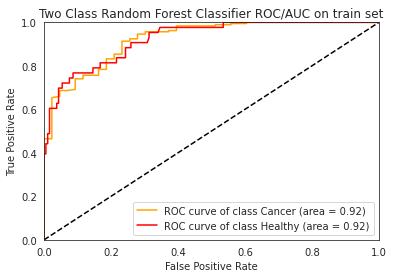

In [ ]:
# Plot ROC for Random Forest Model
class_lookup = {0: 'Cancer', 1: 'Healthy'}
fig, ax = plt.subplots()
create_roc_curve(Y_one_hot, probabilities, class_lookup, 'Two Class Random'
                 ' Forest Classifier ROC/AUC on train set', ax)

## Feature Importance Analysis

In [ ]:
# Rebuild random forest model
forest = estimator.fit(X_train, Y_train)

In [ ]:
print(forest.feature_importances_)
print(type(forest.feature_importances_))
print(X_train.columns)
importances = forest.feature_importances_
cols = X_train.columns

[0.00000000e+00 0.00000000e+00 4.07060084e-05 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
<class 'numpy.ndarray'>
Index(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419',
       'ENSG00000000457', 'ENSG00000000460', 'ENSG00000000938',
       'ENSG00000000971', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167',
       ...
       'ENSG00000273481', 'ENSG00000273483', 'ENSG00000273484',
       'ENSG00000273485', 'ENSG00000273486', 'ENSG00000273487',
       'ENSG00000273488', 'ENSG00000273489', 'ENSG00000273492',
       'ENSG00000273493'],
      dtype='object', name='Column1', length=57736)


In [ ]:
def sum_features(feature_import, label):
    starts_with_label = feature_import.feature.str.startswith(label)
    return feature_import.importance[starts_with_label].sum()

In [ ]:
 # Create function to determine the feature importance 
def create_feature_importance_plot(forest):
  feature_import = pd.DataFrame([Processed_data.drop(['target'], axis=1).columns.values,forest.feature_importances_]).T
  feature_import.columns = ['feature', 'importance']
    #summed_importances = []
    #for label in ['disease', 'reviewer']:
     #   summed_importances.append([label, sum_features(feature_import, label)])
    #summed_importances = pd.DataFrame(summed_importances, columns=['feature','importance'])
    #feature_import.to_pickle(save_fp)
#     print(feature_import ['feature'])
#     for i in feature_import ['feature']:
#         print(i)
  feature_import.sort_values('importance', ascending=False, inplace=True)
  sns.barplot(y='feature', x='importance', data=feature_import.head(18), color='darkorange')
  plt.xlabel('Feature importance')
  plt.ylabel('Feature')
  plt.title('Random Forest Feature Importance')

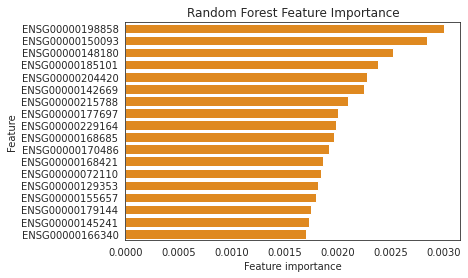

In [ ]:
# Plot feature importance graph
create_feature_importance_plot(forest)

## Test set performance

In [ ]:
#Get probabilites for hold out test set
forest = estimator.fit(X_train, Y_train)
test_prob = forest.predict_proba(X_test)

In [ ]:
# Add labels
Y_test_labels = enc.fit_transform(Y_test)

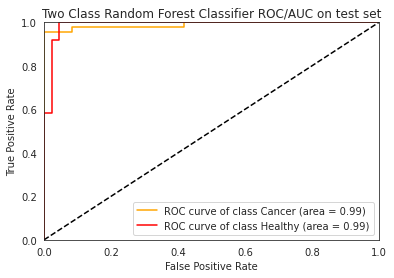

In [ ]:
# PLot test set ROC
fig, ax = plt.subplots()
create_roc_curve(Y_test_labels, test_prob, class_lookup, 'Two Class Random'
                 ' Forest Classifier ROC/AUC on test set', ax)

## Confusion Matrix

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
Y_pred = forest.predict(X_test)
print("Y_test: ", Y_test)
print("Y_pred: ", Y_pred)
conf_mat = confusion_matrix(Y_test, Y_pred , normalize='true')
print(conf_mat)
# disp = plot_confusion_matrix(classifier, X_test, y_test,
# display_labels=class_names, cmap=plt.cm.Blues, normalize='true')

Y_test:  ['c' 'h' 'h' 'c' 'c' 'h' 'h' 'c' 'c' 'h' 'h' 'h' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'h' 'c' 'h' 'c' 'c'
 'c' 'h' 'c' 'c' 'c' 'c' 'h' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'h' 'c']
Y_pred:  ['c' 'h' 'h' 'c' 'c' 'h' 'h' 'c' 'c' 'h' 'c' 'h' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'h' 'c' 'h' 'c' 'c'
 'c' 'h' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'h' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c'
 'c' 'c' 'c']
[[0.97777778 0.02222222]
 [0.25       0.75      ]]


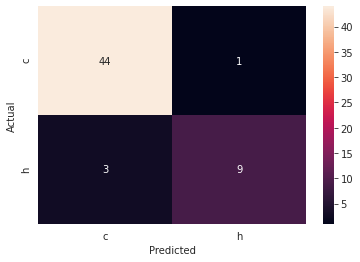

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':    Y_test,
        'y_Predicted': Y_pred
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

## Multi-Class Setting

In [ ]:
#df['Patient type']=0

In [ ]:
""" i=0                                           
for y in x:
  if (y.find('HD') != -1):
    df['list'].iloc[i]='Healthy Donor (HD)'
  #i=i+1
  elif (y.find('liver') != -1):
    df['list'].iloc[i]='Hepatobiliary carcinoma (HBC)'
  #i=i+1
  elif (y.find('Platelet-hiseq') != -1):
    df['list'].iloc[i]='HC'
  elif (y.find('Breast') != -1):
    df['list'].iloc[i]='Breast carcinoma (BrCa)'
  #i=i+1
  elif (y.find('Chol') != -1):
    df['list'].iloc[i]='Hepatobiliary carcinoma (HBC)'
  #i=i+1
  elif (y.find('CRC') != -1):
    df['list'].iloc[i]='Colorectal cancer (CRC)'
  #i=i+1
  elif (y.find('GBM') != -1):
    df['list'].iloc[i]='Glioblastoma (GBM)'
  #i=i+1
  elif (y.find('Pancr') != -1):
    df['list'].iloc[i]='Pancreatic Adenocarcinoma (PAAD)'
  #i=i+1
  elif (y.find('Panc') != -1):
    df['list'].iloc[i]='Pancreatic Adenocarcinoma (PAAD)'
  elif (y.find('Lung') != -1):
    df['list'].iloc[i]='Non-small cell lung cancer (NSCLC)'
  #i=i+1
  elif (y.find('BrCa') != -1):
    df['list'].iloc[i]='Breast carcinoma (BrCa)'
  #i=i+1
  elif (y.find('Control') != -1):
    df['list'].iloc[i]='Healthy Donor (HD)'
  elif (y.find('NSCLC') != -1):
    df['list'].iloc[i]='Non-small cell lung cancer (NSCLC)'
  elif (y.find('Unknown') != -1):
    df['list'].iloc[i]='Hepatobiliary carcinoma (HBC)'
  else:
    df['list'].iloc[i]='Hepatobiliary carcinoma (HBC)'
  i=i+1
  """

" i=0                                           \nfor y in x:\n  if (y.find('HD') != -1):\n    df['list'].iloc[i]='Healthy Donor (HD)'\n  #i=i+1\n  elif (y.find('liver') != -1):\n    df['list'].iloc[i]='Hepatobiliary carcinoma (HBC)'\n  #i=i+1\n  elif (y.find('Platelet-hiseq') != -1):\n    df['list'].iloc[i]='HC'\n  elif (y.find('Breast') != -1):\n    df['list'].iloc[i]='Breast carcinoma (BrCa)'\n  #i=i+1\n  elif (y.find('Chol') != -1):\n    df['list'].iloc[i]='Hepatobiliary carcinoma (HBC)'\n  #i=i+1\n  elif (y.find('CRC') != -1):\n    df['list'].iloc[i]='Colorectal cancer (CRC)'\n  #i=i+1\n  elif (y.find('GBM') != -1):\n    df['list'].iloc[i]='Glioblastoma (GBM)'\n  #i=i+1\n  elif (y.find('Pancr') != -1):\n    df['list'].iloc[i]='Pancreatic Adenocarcinoma (PAAD)'\n  #i=i+1\n  elif (y.find('Panc') != -1):\n    df['list'].iloc[i]='Pancreatic Adenocarcinoma (PAAD)'\n  elif (y.find('Lung') != -1):\n    df['list'].iloc[i]='Non-small cell lung cancer (NSCLC)'\n  #i=i+1\n  elif (y.find('BrC

In [ ]:
""" df['list'] # non-small cell lung cancer, 
           #colorectal cancer, 
           #pancreatic cancer, 
           #glioblastoma, 
           #breast cancer and 
           #hepatobiliary carcinomas
df.list.value_counts()

## Trying K-means Clustering

In [ ]:
"""
from sklearn.cluster import KMeans
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=2, init='k-means++')

# fitting the k means algorithm on scaled data
kmeans.fit(df)
kmeans = KMeans(n_jobs = -1, n_clusters = 5, init='k-means++')
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)
frame = pd.DataFrame(data_scaled)
frame['cluster'] = pred
frame['cluster'].value_counts()"""